In [24]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from reproject import reproject_interp
import copy

In [25]:
big_galfa_fn = "/Volumes/DataDavy/GALFA/DR2/YongTemp/GALFA_HI_W_S1020_V-002.6kms.fits"
big_galfa_data = fits.getdata(big_galfa_fn)

In [26]:
def xy_to_radec_GALFA(x, y, fn):

    #Set wcs transformation
    w = set_wcs_galfa(fn)
    
    #Transformation
    xy = [[x, y]]
    radec = w.wcs_pix2world(xy, 1)
    
    ra = radec[0,0]
    dec = radec[0,1]
    
    # If nan's exist, shift center pixel.
    if (np.isnan(ra)) or (np.isnan(dec)):
        #print "shifting"
        crpix = w.wcs.crpix
        crpix[0] = 360*60+crpix[0]
        w.wcs.crpix = crpix
        
        #Transformation
        xy = [[x, y]]
        radec = w.wcs_pix2world(xy, 1)
    
        ra = radec[0,0]
        dec = radec[0,1]
    
    return ra, dec

In [27]:
def radec_to_xy_GALFA(ra, dec, fn):

    #Set wcs transformation
    w = set_wcs_galfa(fn)
    
    #Transformation
    radec = [[ra, dec]]
    xy = w.wcs_world2pix(radec, 1)
    
    x = xy[0,0]
    y = xy[0,1]
    
    # The transformation returns zero if it's past RA = 360...
    if (np.isnan(x)) or (np.isnan(y)):
        
        #print "shifting"
        crpix = w.wcs.crpix
        crpix[0] = 360*60+crpix[0]
        w.wcs.crpix = crpix

        xy = w.wcs_world2pix(radec, 1)

        x = xy[0,0]
        y = xy[0,1]
    
    return x, y

In [28]:
def set_wcs_galfa(fn):
    """Set wcs transformation from input filename"""
    
    w = wcs.WCS(fn, naxis=2)
    
    return w

In [29]:
def cutout_region(center_ra, center_dec, from_fn, nx = 512, ny = 512):
    
    """
    Given a (RA, DEC) center pixel, cut out a region of size (nx, ny) from from_fn
    """
    
    x_center, y_center = radec_to_xy_GALFA(center_ra, center_dec, from_fn)
    x0 = x_center - nx/2.0
    x1 = x_center + nx/2.0
    y0 = y_center - ny/2.0
    y1 = y_center + ny/2.0
    
    from_data = fits.getdata(from_fn)
    cutout = from_data[y0:y1, x0:x1]
    
    return cutout, x0, x1, y0, y1

This is where we begin running the code. If you set nx = ny, the following works. It fails for nx /= ny. Am I doing something dumb?

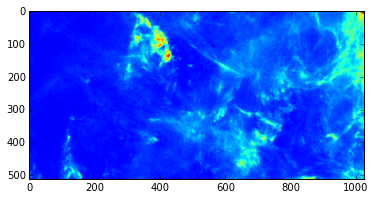

In [30]:
# Select a region of data
center_ra = 120.0
center_dec = 20.0
nx = 1024
ny = 512
cutout1, x0, x1, y0, y1 = cutout_region(center_ra, center_dec, big_galfa_fn, nx = nx, ny = ny)
plt.imshow(cutout1)

In [31]:
big_galfa_hdr = fits.getheader(big_galfa_fn)
cutout_galfa_hdr = fits.getheader(big_galfa_fn)
projected_galfa_hdr = fits.getheader(big_galfa_fn)

Define new CRPIX1 and CRPIX2 values (center of projection in pixels) based on where the cutout lies.

In [32]:
old_crpix1 = big_galfa_hdr["CRPIX1"]
old_crpix2 = big_galfa_hdr["CRPIX2"]

print "x0, y0", x0, y0
print "old crpix1, crpix2", old_crpix1, old_crpix2
ra0, dec0 = xy_to_radec_GALFA(x0, y0, big_galfa_fn)

cutout_crpix1 = old_crpix1 - x0
cutout_crpix2 = old_crpix2 - y0

print cutout_crpix1, cutout_crpix2

x0, y0 13904.4928 1059.4976
old crpix1, crpix2 10816.5 115.5
-3087.99280001 -943.997600005


Define header for cutout region.

In [33]:
cutout_galfa_hdr["NAXIS"] = 2
cutout_galfa_hdr["NAXIS1"] = nx
cutout_galfa_hdr["NAXIS2"] = ny
cutout_galfa_hdr["CRPIX1"] = cutout_crpix1
cutout_galfa_hdr["CRVAL1"] = big_galfa_hdr["CRVAL1"]
cutout_galfa_hdr["CRPIX2"] = cutout_crpix2
cutout_galfa_hdr["CRVAL2"] = big_galfa_hdr["CRVAL2"]

Define header for projected region.

In [34]:
projected_galfa_hdr["NAXIS"] = 2
projected_galfa_hdr["NAXIS1"] = nx
projected_galfa_hdr["NAXIS2"] = ny
projected_galfa_hdr["CRVAL1"] = center_ra
projected_galfa_hdr["CRPIX1"] = nx/2.0 + 0.5
projected_galfa_hdr["CRVAL2"] = center_dec
projected_galfa_hdr["CRPIX2"] = ny/2.0 + 0.5
projected_galfa_hdr["CTYPE1"] = 'RA---TAN'
projected_galfa_hdr["CTYPE2"] = 'DEC--TAN'

In [35]:
new_image, footprint = reproject_interp((cutout1, cutout_galfa_hdr), projected_galfa_hdr)

(512, 1024) (512, 1024)


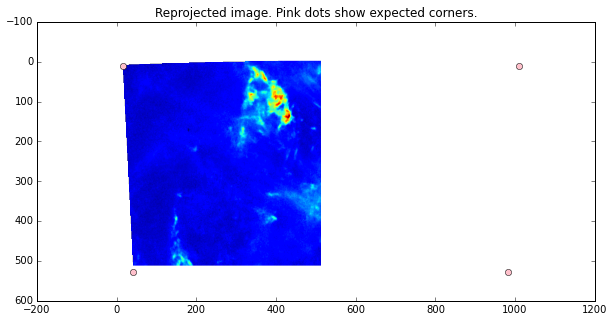

In [36]:
fig = plt.figure(figsize = (10, 10))
plt.imshow(new_image)
print cutout1.shape, new_image.shape

# Where should the corners be?
racorner, deccorner = xy_to_radec_GALFA(0, ny, cutout_galfa_hdr)
xcorner, ycorner = radec_to_xy_GALFA(racorner, deccorner, projected_galfa_hdr)
plt.plot(xcorner, ycorner, 'o', color = "pink")

racorner, deccorner = xy_to_radec_GALFA(nx, ny, cutout_galfa_hdr)
xcorner, ycorner = radec_to_xy_GALFA(racorner, deccorner, projected_galfa_hdr)
plt.plot(xcorner, ycorner, 'o', color = "pink")

racorner, deccorner = xy_to_radec_GALFA(0, 0, cutout_galfa_hdr)
xcorner, ycorner = radec_to_xy_GALFA(racorner, deccorner, projected_galfa_hdr)
plt.plot(xcorner, ycorner, 'o', color = "pink")

racorner, deccorner = xy_to_radec_GALFA(nx, 0, cutout_galfa_hdr)
xcorner, ycorner = radec_to_xy_GALFA(racorner, deccorner, projected_galfa_hdr)
plt.plot(xcorner, ycorner, 'o', color = "pink")

plt.title("Reprojected image. Pink dots show expected corners.")